In [1]:
# Run this first cell
!pip install --upgrade google-cloud-vision google-cloud-translate google-cloud-aiplatform==1.29.0 Pillow
# Some helper libs
!pip install ipywidgets


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 200.9/200.9 kB 4.1 MB/s eta 0:00:00
  Installing build dependencies ... done
  error: subprocess-exited-with-error
  
  × Getting requirements to build wheel did not run successfully.
  │ exit code: 1
  ╰─> See above for output.
  
  note: This error originates from a subprocess, and is likely not a problem with pip.
  Getting requirements to build wheel ... error
error: subprocess-exited-with-error

× Getting requirements to build wheel did not run successfully.
│ exit code: 1
╰─> See above for output.

note: This error originates from a subprocess, and is likely not a problem with pip.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 22.8 MB/s eta 0:00:00


In [2]:
# Upload your JSON key file
from google.colab import files
uploaded = files.upload()  # Choose your JSON file here

# Set environment variable
import os
os.environ["GOOGLE_APPLICATION_CREDENTIALS"] = 'genaihackathonfn-485af4b0fd4f.json'

PROJECT_ID = "genaihackathonfn"
REGION = "asia-south2"


Saving genaihackathonfn-485af4b0fd4f.json to genaihackathonfn-485af4b0fd4f.json


In [7]:
!pip install --upgrade google-cloud-vision
!pip install --upgrade google-cloud-translate
!pip install --upgrade google-cloud-aiplatform

from google.cloud import vision
from google.cloud import translate_v2 as translate
import google.cloud.aiplatform as aiplatform

aiplatform.init(project=PROJECT_ID, location=REGION)

print("✅ All imports and Vertex AI are working!")

  Using cached google_cloud_vision-3.10.2-py3-none-any.whl.metadata (9.6 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 527.9/527.9 kB 9.5 MB/s eta 0:00:00


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 41.6/41.6 kB 1.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.0/8.0 MB 65.3 MB/s eta 0:00:00
  Attempting uninstall: google-cloud-aiplatform
    Found existing installation: google-cloud-aiplatform 1.111.0
    Uninstalling google-cloud-aiplatform-1.111.0:
      Successfully uninstalled google-cloud-aiplatform-1.111.0


✅ All imports and Vertex AI are working!


In [8]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [9]:
folder_path = "/content/drive/MyDrive/ecommerce_images"

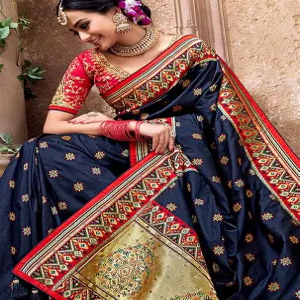

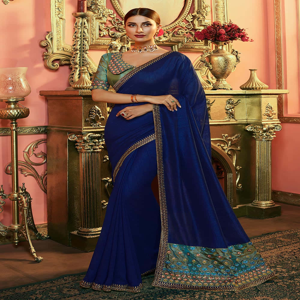

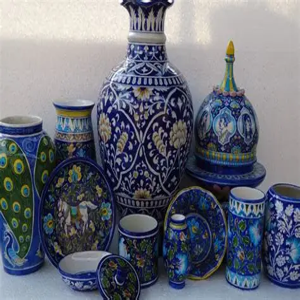

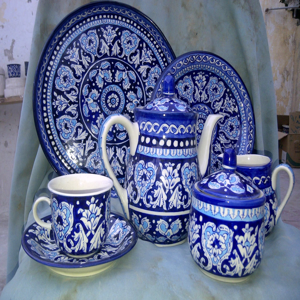

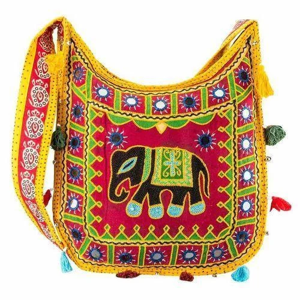

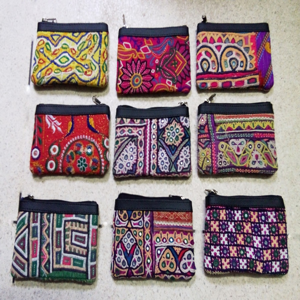

Loaded images: ['saree1.jpg', 'saree2.jpg', 'pottery1.jpg', 'pottery2.jpg', 'bag1.jpg', 'bag2.jpg']


In [10]:
import os
from PIL import Image
from IPython.display import display

images = {}

for filename in os.listdir(folder_path):
    if filename.lower().endswith((".jpg", ".jpeg", ".png")):
        path = os.path.join(folder_path, filename)
        with open(path, "rb") as f:
            images[filename] = f.read()  # raw bytes for Vision
        img = Image.open(path)
        display(img.resize((300,300)))

print("Loaded images:", list(images.keys()))


In [11]:
def vision_tags_from_bytes(img_bytes, max_labels=8):
    from google.cloud import vision
    vision_client = vision.ImageAnnotatorClient() # Initialize the vision client
    image = vision.Image(content=img_bytes)
    response = vision_client.label_detection(image=image, max_results=max_labels)
    labels = response.label_annotations
    tags = [lab.description for lab in labels]
    return tags

# Test first image
first_fn = list(images.keys())[0]
tags = vision_tags_from_bytes(images[first_fn])
print("Vision tags for", first_fn, ":", tags)

Vision tags for saree1.jpg : ['Textile', 'Sari', 'Silk', 'Embroidery', 'Embellishment', 'Motif']


In [12]:
def generate_description(tags, artisan_note):
    try:
        from google.cloud.aiplatform import TextGenerationModel
        model = TextGenerationModel.from_pretrained("text-bison@001")
        tags_str = ", ".join(tags[:6])
        prompt = (f"You are an artisan writing about your handcrafted product. "
                  f"Tags: {tags_str}. Artisan note: {artisan_note}\n\n"
                  "Produce a short, authentic 3-4 sentence product description.")
        resp = model.predict(prompt, max_output_tokens=220)
        return resp.text
    except:
        tags_str = ", ".join(tags[:6])
        return f"{artisan_note}. Tags: {tags_str}."


In [13]:
def translate_text(text, target_language_code="hi"):
    from google.cloud import translate
    translate_client = translate.TranslationServiceClient()
    parent = f"projects/{PROJECT_ID}/locations/global"
    response = translate_client.translate_text(
        request={
            "parent": parent,
            "contents": [text],
            "mime_type": "text/plain",
            "target_language_code": target_language_code,
        }
    )
    return response.translations[0].translated_text

In [15]:
import pandas as pd

def build_product_card(image_bytes, artisan_note, max_tags=6):
    tags = vision_tags_from_bytes(image_bytes, max_labels=max_tags)
    description = generate_description(tags, artisan_note)
    hi = translate_text(description, "hi")
    es = translate_text(description, "es")
    return {"tags": tags, "description_en": description, "description_hi": hi, "description_es": es}

default_note = "Handcrafted using traditional techniques by a local artisan."
rows = []

for fn, data in images.items():
    card = build_product_card(data, default_note)
    card["filename"] = fn
    rows.append(card)

df = pd.DataFrame(rows)
df


,tags,description_en,description_hi,description_es,filename
0,"[Textile, Sari, Silk, Embroidery, Embellishmen...",Handcrafted using traditional techniques by a ...,स्थानीय कारीगर द्वारा पारंपरिक तकनीकों का उपयो...,Hecho a mano con técnicas tradicionales por un...,saree1.jpg
1,"[Sari, Silk]",Handcrafted using traditional techniques by a ...,स्थानीय कारीगर द्वारा पारंपरिक तकनीकों का उपयो...,Hecho a mano con técnicas tradicionales por un...,saree2.jpg
2,"[Blue, Blue and white pottery, Porcelain, Serv...",Handcrafted using traditional techniques by a ...,स्थानीय कारीगर द्वारा पारंपरिक तकनीकों का उपयो...,Hecho a mano con técnicas tradicionales por un...,pottery1.jpg
3,"[Blue, Blue and white pottery, Serveware, Dish...",Handcrafted using traditional techniques by a ...,स्थानीय कारीगर द्वारा पारंपरिक तकनीकों का उपयो...,Hecho a mano con técnicas tradicionales por un...,pottery2.jpg
4,"[Working animal, Indian elephant, Shoulder Bag...",Handcrafted using traditional techniques by a ...,स्थानीय कारीगर द्वारा पारंपरिक तकनीकों का उपयो...,Hecho a mano con técnicas tradicionales por un...,bag1.jpg
5,"[Bag, Wallet, Textile, Wristlet, Luggage & bag...",Handcrafted using traditional techniques by a ...,स्थानीय कारीगर द्वारा पारंपरिक तकनीकों का उपयो...,Hecho a mano con técnicas tradicionales por un...,bag2.jpg



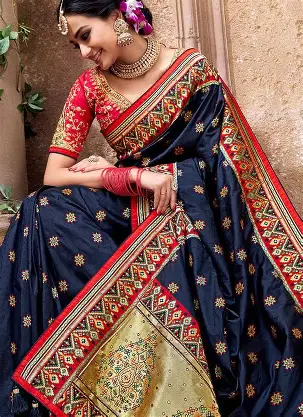
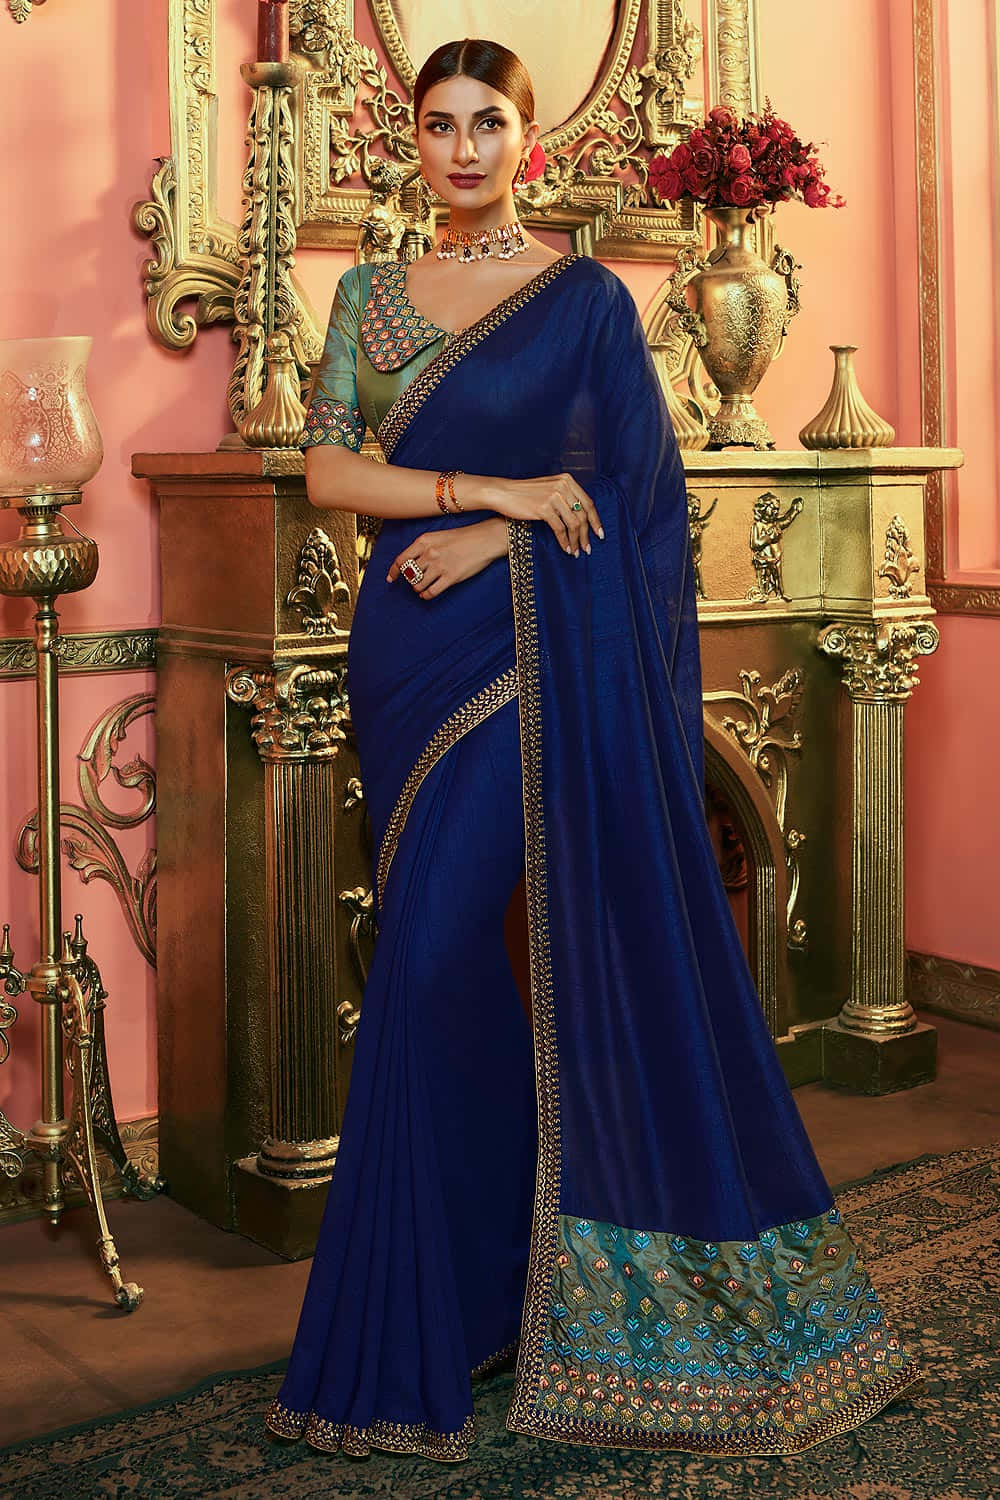
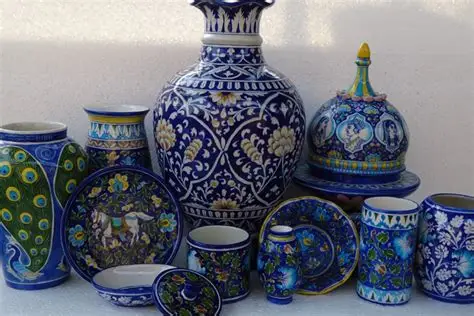
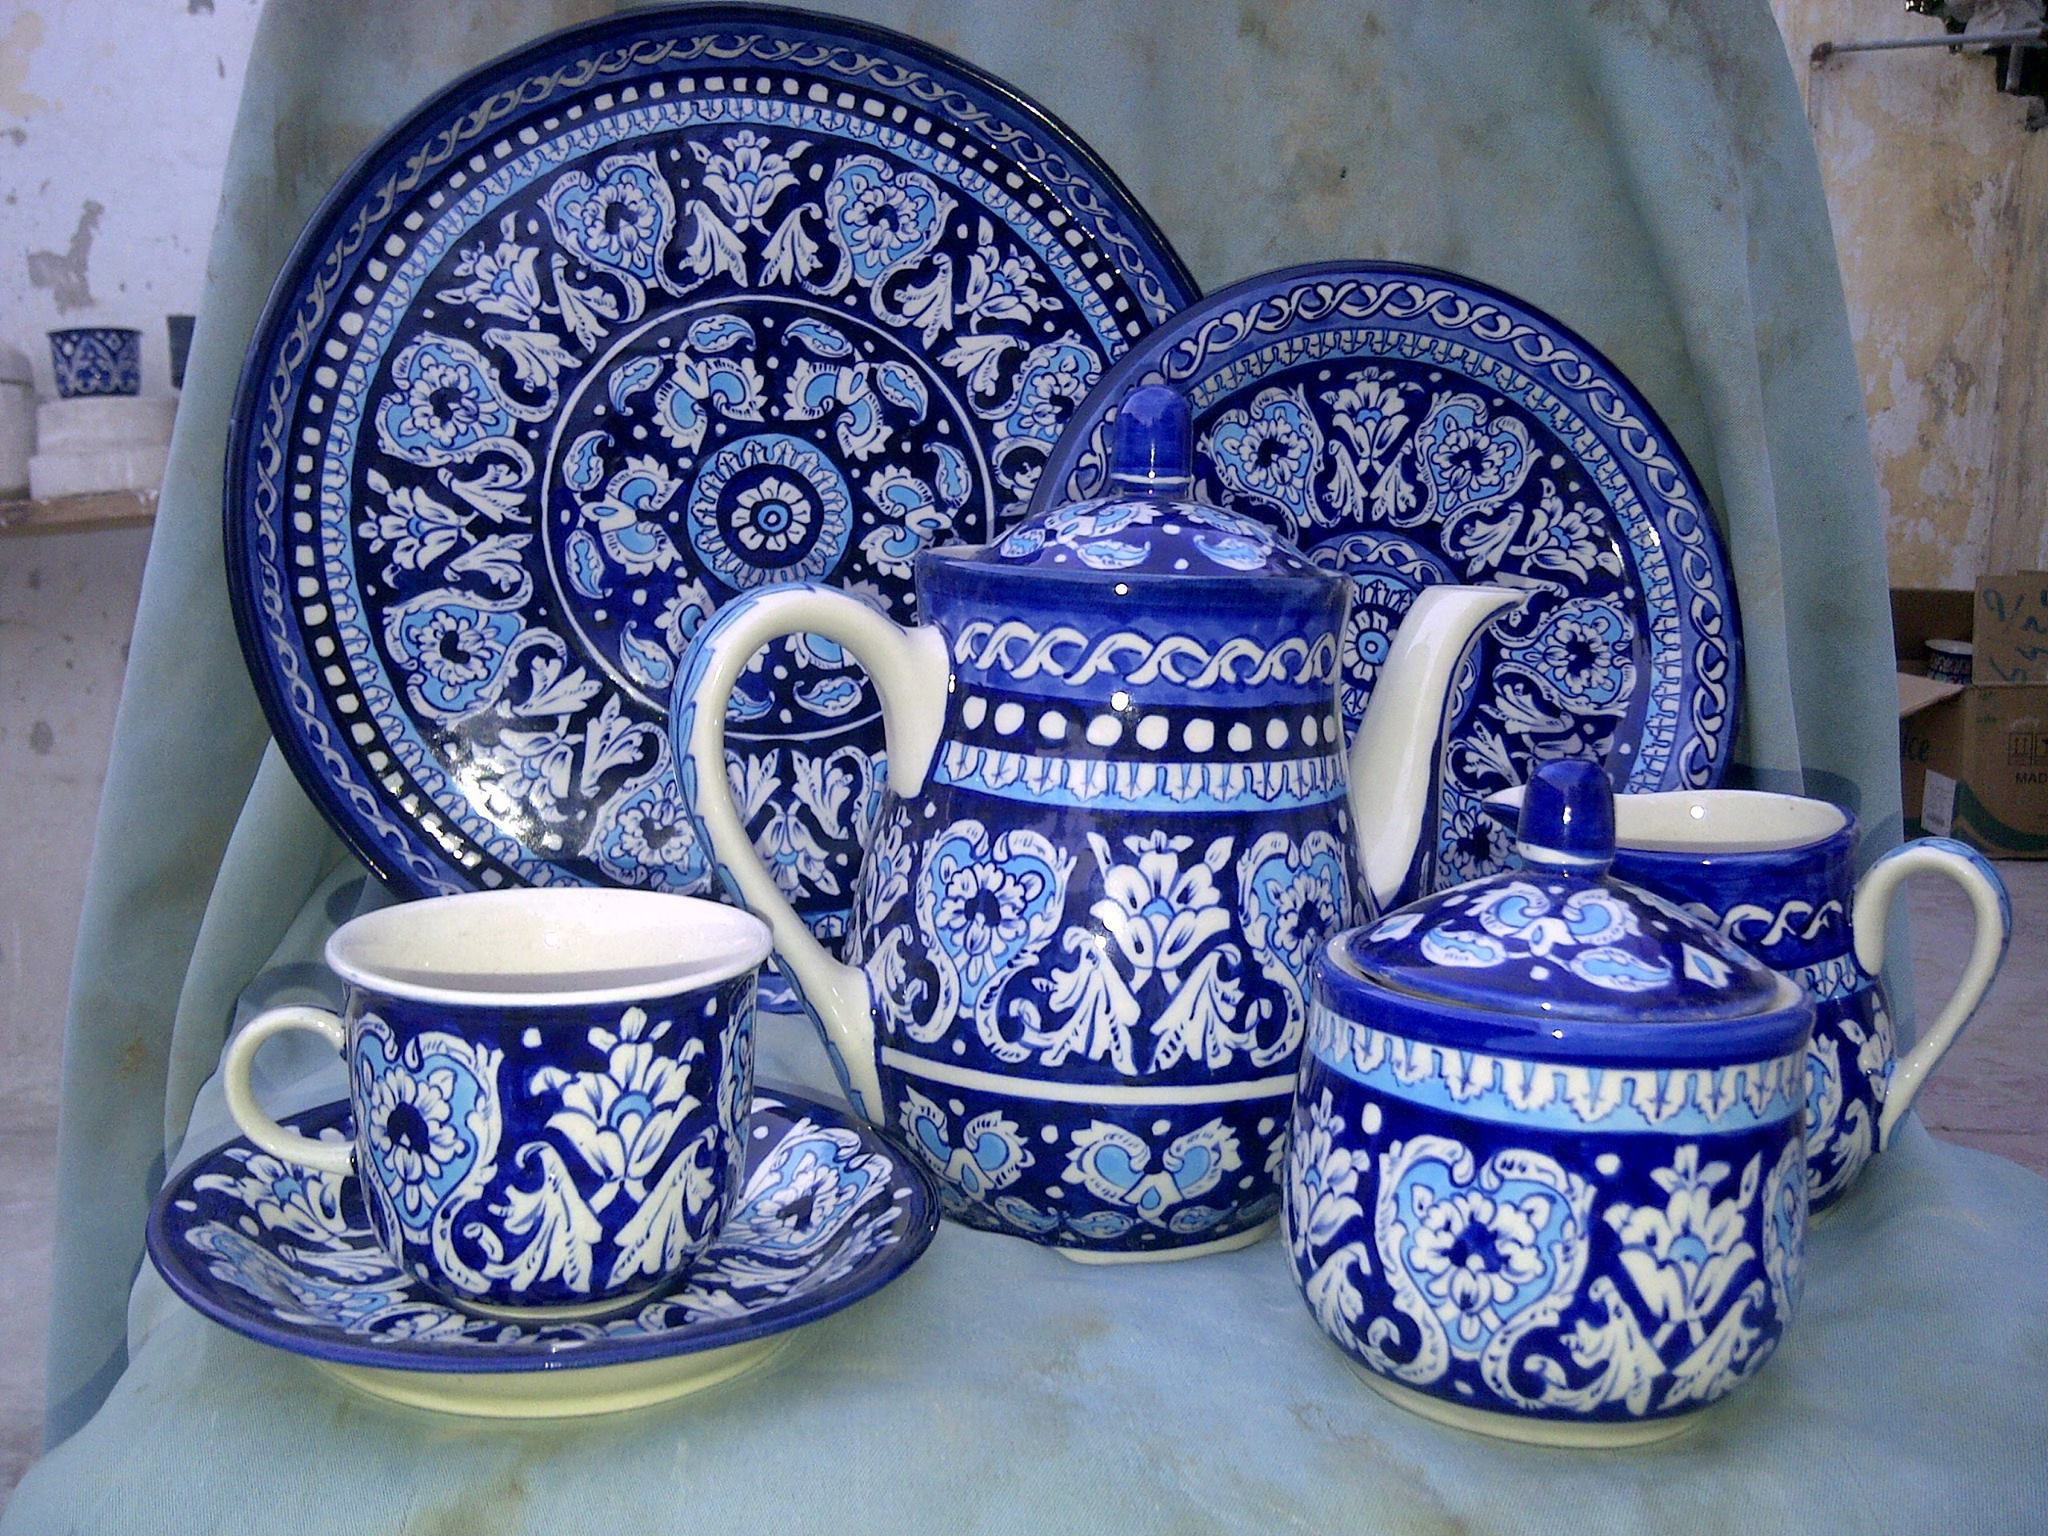
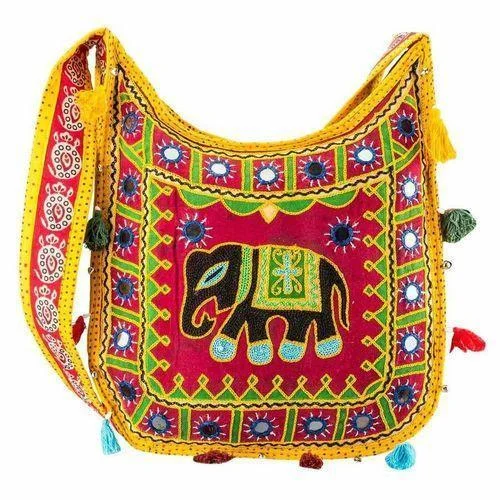
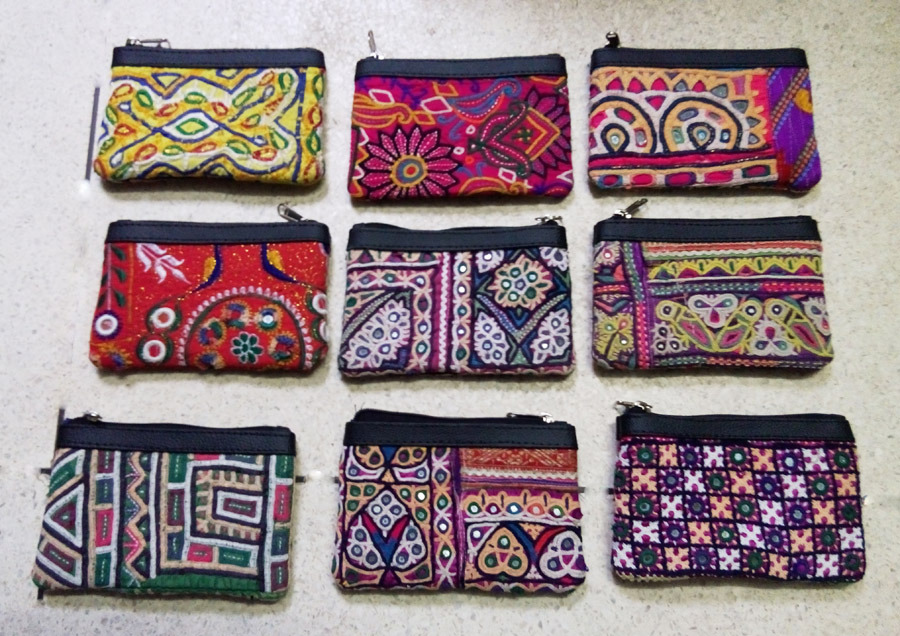

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [16]:
import base64
from IPython.display import HTML, display

def make_html_card(filename, image_bytes, row):
    b64 = base64.b64encode(image_bytes).decode('utf-8')
    img_tag = f'<img src="data:image/jpeg;base64,{b64}" width="200"/>'
    tags = ", ".join(row["tags"])
    html = f"""
    <div style="border:1px solid #ddd;padding:12px;margin:6px;border-radius:8px;width:700px;">
      <div style="display:flex;gap:12px;">
        <div>{img_tag}</div>
        <div>
          <h3>{filename}</h3>
          <b>Tags:</b> {tags}<br/><br/>
          <b>EN:</b> {row['description_en']}<br/><br/>
          <b>HI:</b> {row['description_hi']}<br/><br/>
          <b>ES:</b> {row['description_es']}<br/>
        </div>
      </div>
    </div>
    """
    return html

cards_html = ""
for _, r in df.iterrows():
    cards_html += make_html_card(r['filename'], images[r['filename']], r)

display(HTML(cards_html))

# Optional CSV download
df.to_csv("product_cards.csv", index=False)
from google.colab import files
files.download("product_cards.csv")


In [20]:
!pip install gradio --upgrade


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.4/60.4 MB 14.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 325.2/325.2 kB 17.6 MB/s eta 0:00:00
  Attempting uninstall: gradio-client
    Found existing installation: gradio_client 1.12.1
    Uninstalling gradio_client-1.12.1:
      Successfully uninstalled gradio_client-1.12.1
  Attempting uninstall: gradio
    Found existing installation: gradio 5.44.1
    Uninstalling gradio-5.44.1:
      Successfully uninstalled gradio-5.44.1


In [21]:
import gradio as gr
from PIL import Image
import io
import pandas as pd
import base64


In [22]:
def process_image(img_file):
    # Read bytes
    img_bytes = img_file.read()

    # Display image
    img = Image.open(io.BytesIO(img_bytes))

    # Vision tags
    tags = vision_tags_from_bytes(img_bytes)

    # Generate description
    description_en = generate_description(tags, "Handcrafted using traditional techniques by a local artisan.")

    # Translations
    description_hi = translate_text(description_en, "hi")
    description_es = translate_text(description_en, "es")

    # Prepare a DataFrame (optional) for CSV download
    df = pd.DataFrame([{
        "tags": ", ".join(tags),
        "description_en": description_en,
        "description_hi": description_hi,
        "description_es": description_es
    }])

    # Convert CSV to string for download
    csv_str = df.to_csv(index=False)

    # Prepare HTML card
    b64 = base64.b64encode(img_bytes).decode('utf-8')
    img_tag = f'<img src="data:image/jpeg;base64,{b64}" width="250"/>'
    html_card = f"""
    <div style="border:1px solid #ddd;padding:12px;margin:6px;border-radius:8px;width:700px;">
      <div style="display:flex;gap:12px;">
        <div>{img_tag}</div>
        <div>
          <b>Tags:</b> {', '.join(tags)}<br/><br/>
          <b>EN:</b> {description_en}<br/><br/>
          <b>HI:</b> {description_hi}<br/><br/>
          <b>ES:</b> {description_es}<br/>
        </div>
      </div>
    </div>
    """

    return html_card, csv_str


In [23]:
iface = gr.Interface(
    fn=process_image,
    inputs=gr.File(type="binary", label="Upload Product Image"),
    outputs=[
        gr.HTML(label="Product Card Preview"),
        gr.File(label="Download CSV")
    ],
    title="AI-powered E-commerce Product Cards",
    description="Upload a product image → Get AI tags, multi-language description, and CSV download"
)

In [24]:
iface.launch()


It looks like you are running Gradio on a hosted Jupyter notebook, which requires `share=True`. Automatically setting `share=True` (you can turn this off by setting `share=False` in `launch()` explicitly).

Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
* Running on public URL: https://bf4bbdc14e5a68aa0c.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)


In [ ]:
# !pip install gradio -q

# import gradio as gr
# import pandas as pd
# import io
# import base64

# # Wrap your pipeline in one function
# def process_product_image(image, artisan_note="Handcrafted using traditional techniques."):
#     # Convert uploaded PIL image -> bytes
#     buf = io.BytesIO()
#     image.save(buf, format="PNG")
#     img_bytes = buf.getvalue()

#     # Vision tags
#     tags = vision_tags_from_bytes(img_bytes)

#     # Description
#     description_en = generate_description(tags, artisan_note)

#     # Translations
#     description_hi = translate_text(description_en, "hi")
#     description_es = translate_text(description_en, "es")

#     # Create CSV in memory
#     df = pd.DataFrame([{
#         "tags": ", ".join(tags),
#         "description_en": description_en,
#         "description_hi": description_hi,
#         "description_es": description_es
#     }])
#     csv_bytes = df.to_csv(index=False).encode("utf-8")
#     csv_b64 = "data:text/csv;base64," + base64.b64encode(csv_bytes).decode()

#     return (
#         tags,
#         description_en,
#         description_hi,
#         description_es,
#         csv_b64
#     )

# # Gradio UI
# with gr.Blocks(theme=gr.themes.Soft()) as demo:
#     gr.Markdown("## 🌸 AI-powered Marketplace for Local Artisans")
#     gr.Markdown("Upload a product image → Get AI tags, authentic description, and translations (EN, HI, ES).")

#     with gr.Row():
#         with gr.Column():
#             image_in = gr.Image(type="pil", label="Upload Product Image")
#             note_in = gr.Textbox(value="Handcrafted using traditional techniques by a local artisan.",
#                                  label="Artisan Note (optional)")
#             btn = gr.Button("✨ Generate Card")

#         with gr.Column():
#             tags_out = gr.Label(label="AI Tags")
#             desc_en = gr.Textbox(label="English Description")
#             desc_hi = gr.Textbox(label="Hindi Description")
#             desc_es = gr.Textbox(label="Spanish Description")
#             csv_link = gr.File(label="Download CSV")

#     def run_pipeline(image, note):
#         tags, en, hi, es, csv_b64 = process_product_image(image, note)
#         # Save temp file so Gradio can download
#         with open("result.csv", "wb") as f:
#             f.write(pd.DataFrame([{
#                 "tags": ", ".join(tags),
#                 "description_en": en,
#                 "description_hi": hi,
#                 "description_es": es
#             }]).to_csv(index=False).encode("utf-8"))
#         return tags, en, hi, es, "result.csv"

#     btn.click(run_pipeline, inputs=[image_in, note_in],
#               outputs=[tags_out, desc_en, desc_hi, desc_es, csv_link])

# # Launch app with public link
# demo.launch(share=True)


Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
* Running on public URL: https://13e6621ea5a0f8af28.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)


In [31]:
!pip install streamlit pyngrok -q

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.0/10.0 MB 62.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.9/6.9 MB 96.8 MB/s eta 0:00:00


In [32]:
%%writefile app.py
# pip install streamlit pyngrok -q

import streamlit as st
import io, base64
from PIL import Image
import pandas as pd

# --- GOOGLE CLOUD CLIENTS ---
from google.cloud import vision, translate
import google.cloud.aiplatform as aiplatform

# --- CONFIG (replace with your project/region) ---
PROJECT_ID = "genaihackathonfn"
LOCATION = "asia-south2"

# init clients
vision_client = vision.ImageAnnotatorClient()
translate_client = translate.TranslationServiceClient()
aiplatform.init(project=PROJECT_ID, location=LOCATION)

# --- FUNCTIONS ---
def vision_tags_from_bytes(img_bytes, max_labels=6):
    try:
        image = vision.Image(content=img_bytes)
        response = vision_client.label_detection(image=image, max_results=max_labels)
        return [lab.description for lab in response.label_annotations]
    except Exception:
        return ["artisan", "handmade", "craft"]

def generate_description(tags, artisan_note):
    tags_str = ", ".join(tags)
    try:
        from google.cloud.aiplatform import TextGenerationModel
        model = TextGenerationModel.from_pretrained("text-bison@001")
        prompt = (f"Product tags: {tags_str}. Artisan note: {artisan_note}. "
                  "Write a short 3–4 sentence authentic product description.")
        resp = model.predict(prompt, max_output_tokens=200)
        return getattr(resp, "text", getattr(resp, "predictions", [prompt]))[0]
    except Exception:
        return artisan_note + " Beautiful handcrafted item."

def translate_text(text, lang="hi"):
    try:
        parent = f"projects/{PROJECT_ID}/locations/global"
        response = translate_client.translate_text(
            request={
                "parent": parent,
                "contents": [text],
                "mime_type": "text/plain",
                "target_language_code": lang,
            }
        )
        return response.translations[0].translated_text
    except Exception:
        return "(Translation unavailable)"

def make_card_html(image, tags, en, hi, es):
    buf = io.BytesIO()
    image.save(buf, format="PNG")
    img_b64 = base64.b64encode(buf.getvalue()).decode()
    img_tag = f'<img src="data:image/png;base64,{img_b64}" width="220" style="border-radius:12px;"/>'

    return f"""
    <div style="border:1px solid #ddd; padding:15px; margin:15px;
                border-radius:15px; background:#fafafa; width:750px;">
      <div style="display:flex; gap:20px;">
        {img_tag}
        <div style="flex:1;">
          <h3 style="margin-top:0;">🌸 Artisan Product</h3>
          <b>Tags:</b> {", ".join(tags)}<br/><br/>
          <b>EN:</b> {en}<br/><br/>
          <b>HI:</b> {hi}<br/><br/>
          <b>ES:</b> {es}
        </div>
      </div>
    </div>
    """

# --- STREAMLIT APP ---
st.set_page_config(page_title="AI Marketplace", layout="centered")
st.title("🌸 AI-powered Marketplace for Local Artisans")
st.write("Upload a product image → Get AI tags, authentic descriptions, translations (EN, HI, ES).")

uploaded_file = st.file_uploader("Upload Product Image", type=["jpg", "jpeg", "png"])
artisan_note = st.text_input("Artisan Note", "Handcrafted using traditional techniques by a local artisan.")

if uploaded_file:
    image = Image.open(uploaded_file)
    st.image(image, caption="Uploaded Product", width=300)

    if st.button("✨ Generate Product Card"):
        img_bytes = uploaded_file.read()
        tags = vision_tags_from_bytes(img_bytes)
        en = generate_description(tags, artisan_note)
        hi = translate_text(en, "hi")
        es = translate_text(en, "es")

        # show HTML card
        card_html = make_card_html(image, tags, en, hi, es)
        st.markdown(card_html, unsafe_allow_html=True)

        # CSV export
        df = pd.DataFrame([{
            "tags": ", ".join(tags),
            "description_en": en,
            "description_hi": hi,
            "description_es": es
        }])
        csv = df.to_csv(index=False).encode()
        st.download_button("📥 Download CSV", csv, "product_card.csv", "text/csv")


Overwriting app.py


In [ ]:
from pyngrok import ngrok
import os
import subprocess
import time

# Set ngrok authtoken manually or via Colab secrets
NGROK_AUTH_TOKEN = os.environ.get("NGROK_AUTH_TOKEN")  # Make sure you set this in Colab secrets
if NGROK_AUTH_TOKEN:
    os.environ["NGROK_AUTH_TOKEN"] = NGROK_AUTH_TOKEN
    print("Ngrok authtoken loaded from environment.")
else:
    print("Ngrok authtoken not found. Add it to Colab environment variables as 'NGROK_AUTH_TOKEN'.")

# Run Streamlit app in the background (headless mode)
process = subprocess.Popen(
    ["streamlit", "run", "app.py", "--server.headless", "true"],
    stdout=subprocess.PIPE,
    stderr=subprocess.PIPE
)
print("Streamlit app started in the background.")

# Give Streamlit some time to start
time.sleep(5)  # Increase if app takes longer to start

# Get public URL via ngrok
try:
    public_url = ngrok.connect(8501).public_url
    print("🌍 Streamlit app URL:", public_url)
except Exception as e:
    print(f"Error connecting to ngrok: {e}")
    # Print Streamlit logs for debugging
    stdout, stderr = process.communicate()
    print("Streamlit stdout:", stdout.decode())
    print("Streamlit stderr:", stderr.decode())


Ngrok authtoken loaded from environment.
Streamlit app started in the background.


ERROR:pyngrok.process.ngrok:t=2025-09-21T15:53:33+0000 lvl=eror msg="failed to reconnect session" obj=tunnels.session err="authentication failed: Usage of ngrok requires a verified account and authtoken.\n\nSign up for an account: https://dashboard.ngrok.com/signup\nInstall your authtoken: https://dashboard.ngrok.com/get-started/your-authtoken\r\n\r\nERR_NGROK_4018\r\n"
ERROR:pyngrok.process.ngrok:t=2025-09-21T15:53:33+0000 lvl=eror msg="session closing" obj=tunnels.session err="authentication failed: Usage of ngrok requires a verified account and authtoken.\n\nSign up for an account: https://dashboard.ngrok.com/signup\nInstall your authtoken: https://dashboard.ngrok.com/get-started/your-authtoken\r\n\r\nERR_NGROK_4018\r\n"
ERROR:pyngrok.process.ngrok:t=2025-09-21T15:53:33+0000 lvl=eror msg="terminating with error" obj=app err="authentication failed: Usage of ngrok requires a verified account and authtoken.\n\nSign up for an account: https://dashboard.ngrok.com/signup\nInstall your aut

Error connecting to ngrok: The ngrok process errored on start: authentication failed: Usage of ngrok requires a verified account and authtoken.\n\nSign up for an account: https://dashboard.ngrok.com/signup\nInstall your authtoken: https://dashboard.ngrok.com/get-started/your-authtoken\r\n\r\nERR_NGROK_4018\r\n.
